In [2]:
!pip install ta
!pip install tsfresh

  Created wheel for ta: filename=ta-0.7.0-cp36-none-any.whl size=28718 sha256=0265faf833b99a4ed1828725aadb75d7447fdd4b202e111803ffc28db4af51e6
  Stored in directory: /root/.cache/pip/wheels/dd/88/30/de9553fb54a474eb7480b937cdbb140bdda613d29cf4da7994
Successfully built ta
     |████████████████████████████████| 92kB 6.8MB/s 
     |████████████████████████████████| 675kB 34.5MB/s 
     |████████████████████████████████| 102kB 13.6MB/s 
     |████████████████████████████████| 102kB 13.2MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7667 sha256=7bb5ebb9f89bc99abcc38de02a7eb0382b52863dc99d2b1b6694834b314a9bb7
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4042 sha256=1e2d49996a95f490166cf312b1d1b28b65bb0a881f65a82790c700bebbe7f801
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf

In [3]:
import numpy as np
import pandas as pd
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
import pandas_datareader as pdr
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
import ta
from ta import add_all_ta_features
import tsfresh
from tsfresh.feature_extraction import extract_features

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
## Download some data
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2021, 1, 1)
db_usd = pdr.data.DataReader(['BTC-USD'], 'yahoo', start, end)


db_usd.columns = db_usd.columns.droplevel('Symbols')
db_usd.head()

Attributes,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2014-09-16,457.334015,457.334015,468.174011,452.421997,465.864014,21056800.0
2014-09-17,424.440002,424.440002,456.859985,413.104004,456.859985,34483200.0
2014-09-18,394.795990,394.795990,427.834991,384.532013,424.102997,37919700.0
2014-09-19,408.903992,408.903992,423.295990,389.882996,394.673004,36863600.0
2014-09-20,398.821014,398.821014,412.425995,393.181000,408.084991,26580100.0


## **Features correlation**

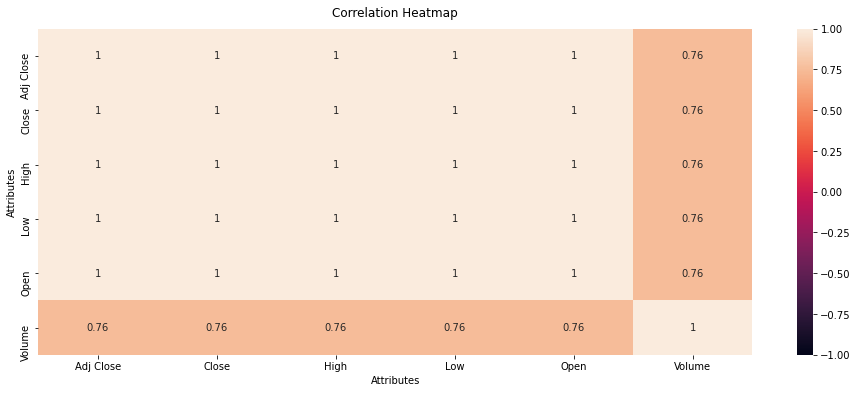

In [5]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(db_usd.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

We will drop highly correlated columns. 

Consequently, we will only keep the **Close** and **Volume** values.

In [6]:
features = db_usd[['Close','Volume']]

# **Stationnarity tests**

Financial data is usually non-stationnary.

Many research papers highlighted the fact that stationnary datasets improve the accuracy of predictive models.

In [7]:
# Augmented Dicky-Fuller stationnarity test

# If p-value > 0.05: we fail to reject the null hypothesis (H0) => the data has a unit root and is non-stationary.
# If p-value <= 0.05: we reject the null hypothesis (H0) => the data does not have a unit root and is stationary.

for column in ['Close', 'Volume']:
  adfuller_test = adfuller(features[column])
  print('Results of the ADF test for the ' + column)
  print('ADF Statistic: %f' % adfuller_test[0])
  print('p-value: %f' % adfuller_test[1])
  print('Critical Values:')
  for key, value in adfuller_test[4].items():
	  print('\t%s: %.3f' % (key, value))

Results of the ADF test for the Close
ADF Statistic: 2.008150
p-value: 0.998683
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Results of the ADF test for the Volume
ADF Statistic: 0.035457
p-value: 0.961368
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


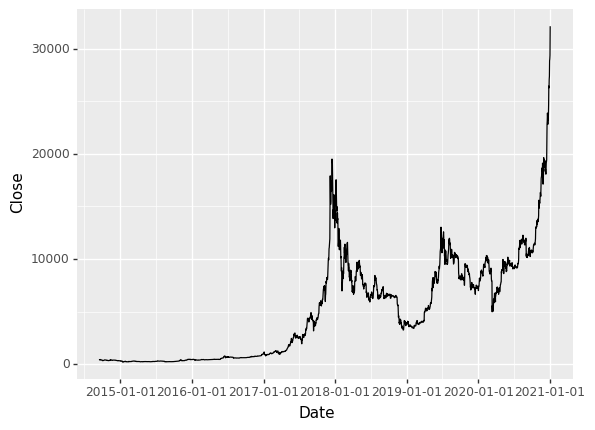

<ggplot: (8730677306758)>

In [8]:
from plotnine import ggplot, aes, geom_line

(ggplot(features.reset_index(), aes(x='Date', y='Close')) + geom_line())

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


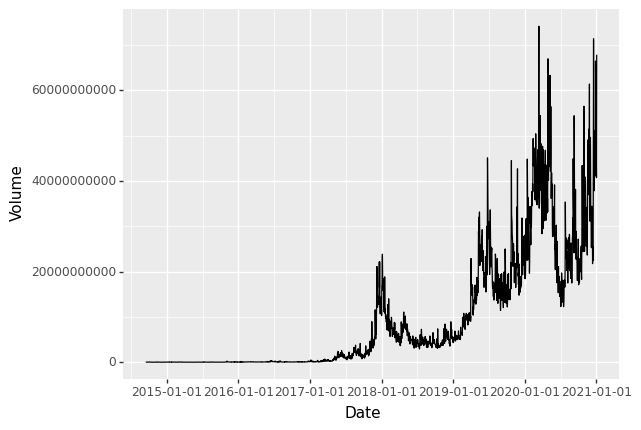

<ggplot: (-9223363306177469005)>

In [9]:
from plotnine import ggplot, aes, geom_line

(ggplot(features.reset_index(), aes(x='Date', y='Volume')) + geom_line())

*It* is clear that the Close and Volume are non-stationnary. Therefore, we will compute their first order derivatives in order to have two stationnary columns.

In [10]:
features['Close_diff'] = features['Close'].diff(1)
features['Volume_diff'] = features['Volume'].diff(1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
# Augmented Dicky-Fuller stationnarity test on the differenciated Close and Volume columns

for column in ['Close_diff', 'Volume_diff']:
  adfuller_test = adfuller(features[column][1:])
  print('Results of the ADF test for the ' + column)
  print('ADF Statistic: %f' % adfuller_test[0])
  print('p-value: %f' % adfuller_test[1])
  print('Critical Values:')
  for key, value in adfuller_test[4].items():
	  print('\t%s: %.3f' % (key, value))

Results of the ADF test for the Close_diff
ADF Statistic: -5.575249
p-value: 0.000001
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Results of the ADF test for the Volume_diff
ADF Statistic: -12.848063
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


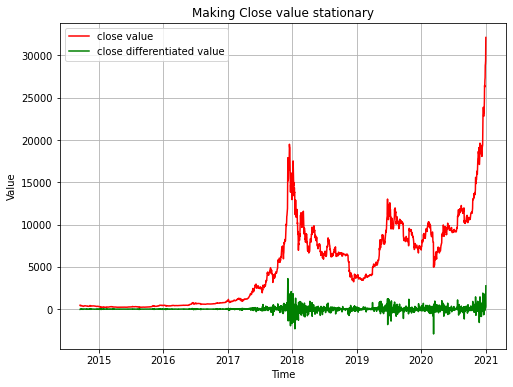

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(features['Close'], "r", label="close value")
plt.plot(features['Close_diff'], "g", label="close differentiated value")
plt.title('Making Close value stationary')
plt.ylabel('Value')
plt.xlabel('Time')
plt.grid()
plt.legend()
plt.show()

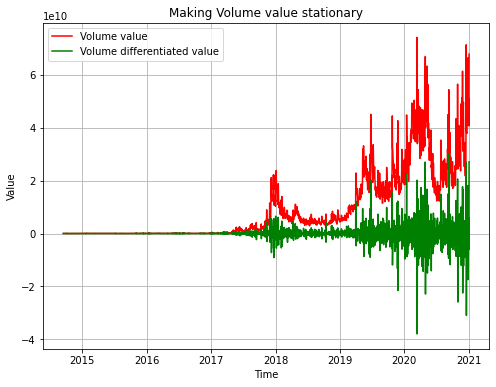

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(features['Volume'], "r", label="Volume value")
plt.plot(features['Volume_diff'], "g", label="Volume differentiated value")
plt.title('Making Volume value stationary')
plt.ylabel('Value')
plt.xlabel('Time')
plt.grid()
plt.legend()
plt.show()

# **Denoising using a Wavelet decomposition**

Financial data often contains a lot of noise, which makes it harder for predictive models to extract any useful and viable information from this kind of data.

We will be using the wavelet theory in order to denoise the Close and Volume values.

In [14]:
for column in ['Close', 'Volume']: 
  data = db_usd[column]
  # Create wavelet object and define parameters
  w = pywt.Wavelet('sym4')
  maxlev = pywt.dwt_max_level(len(data), w.dec_len)
  print("Maximum level of decomposition for the " + column + ' is ' + str(maxlev))
  threshold = 0.04 # Threshold for filtering

  # Decompose into wavelet components, to the level selected:
  coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
  for i in range(1, len(coeffs)):
    coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
  column_name = column +'_denoised'
  features[column_name] = pywt.waverec(coeffs, 'sym4')


Maximum level of decomposition for the Close is 8
Maximum level of decomposition for the Volume is 8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
features.head()

Attributes,Close,Volume,Close_diff,Volume_diff,Close_denoised,Volume_denoised
Date,,,,,,
2014-09-16,457.334015,21056800.0,NaN,NaN,391.534454,2.780399e+07
2014-09-17,424.440002,34483200.0,-32.894012,13426400.0,391.365262,2.779118e+07
2014-09-18,394.795990,37919700.0,-29.644012,3436500.0,391.169544,2.777854e+07
2014-09-19,408.903992,36863600.0,14.108002,-1056100.0,390.870224,2.776696e+07
2014-09-20,398.821014,26580100.0,-10.082977,-10283500.0,390.516734,2.775598e+07


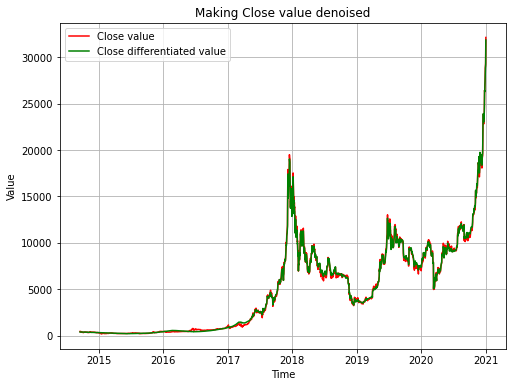

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(features['Close'], "r", label="Close value")
plt.plot(features['Close_denoised'], "g", label="Close differentiated value")
plt.title('Making Close value denoised')
plt.ylabel('Value')
plt.xlabel('Time')
plt.grid()
plt.legend()
plt.show()

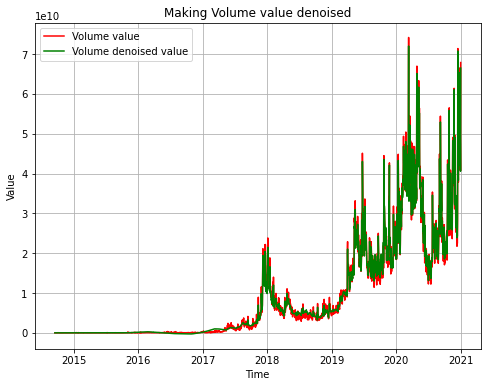

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(features['Volume'], "r", label="Volume value")
plt.plot(features['Volume_denoised'], "g", label="Volume denoised value")
plt.title('Making Volume value denoised')
plt.ylabel('Value')
plt.xlabel('Time')
plt.grid()
plt.legend()
plt.show()

# **Financial features**

We will be using the TA (technical analysis) library to compute financial features.

In [18]:
# Add all ta features
financial_features = add_all_ta_features(
    db_usd, open="Open", high="High", low="Low", close="Close", volume="Volume")

financial_features = financial_features.drop(columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'])
financial_features = financial_features.dropna(axis=1)

financial_features.head()

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Attributes,volume_adi,volume_obv,volume_vpt,volume_nvi,volatility_atr,volatility_bbhi,volatility_bbli,volatility_kch,volatility_kcl,volatility_kcp,volatility_kchi,volatility_kcli,trend_adx,trend_adx_pos,trend_adx_neg,trend_ichimoku_b,trend_visual_ichimoku_b,trend_psar_up_indicator,trend_psar_down_indicator,others_dr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-16,-7.924336e+06,21056800.0,2.292552e+07,1000.000000,0.0,0.0,0.0,475.062022,443.557994,0.437278,0.0,0.0,0.0,0.0,0.0,460.298004,4791.162412,0.0,0.0,-90.757076,0.000000
2014-09-17,-2.454020e+07,-13426400.0,-2.159076e+07,1000.000000,0.0,0.0,0.0,475.143000,415.635005,0.147963,0.0,0.0,0.0,0.0,0.0,440.639008,4791.162412,0.0,0.0,-7.192558,-7.192558
2014-09-18,-4.448391e+07,-51346100.0,-5.128636e+06,1000.000000,0.0,0.0,0.0,465.325548,396.784899,-0.029018,0.0,1.0,0.0,0.0,0.0,426.353012,4791.162412,0.0,1.0,-6.984265,-13.674475
2014-09-19,-3.937687e+07,-14482500.0,-1.331094e+06,1035.734916,0.0,0.0,0.0,459.187658,391.075673,0.261750,0.0,0.0,0.0,0.0,0.0,426.353012,4791.162412,0.0,0.0,3.573492,-10.589639
2014-09-20,-5.037763e+07,-41062600.0,6.618911e+05,1010.195201,0.0,0.0,0.0,451.494326,389.306740,0.152993,0.0,0.0,0.0,0.0,0.0,426.353012,4791.162412,0.0,0.0,-2.465854,-12.794369


# **Statistical features**

We will be using the TSFresh library to compute statistical features.

In [19]:
## Selecting the features that we want to compute 
settings = {'abs_energy' : None,
            'absolute_sum_of_changes': None,
            'autocorrelation': [{'lag': 15}, {'lag': 30}, {'lag': 60}, {'lag': 90}],
            'ar_coefficient': [{'coeff': 90,'k': 90}],
            'augmented_dickey_fuller': [{'attr': 'pvalue'}],
            'count_above_mean': None,
            'count_below_mean': None,
            'first_location_of_maximum': None,
            'first_location_of_minimum': None,
            'kurtosis': None,
            'last_location_of_maximum': None,
            'last_location_of_minimum': None,
            'longest_strike_above_mean': None,
            'longest_strike_below_mean': None,
            'maximum': None,
            'minimum': None,
            'median': None,
            'mean_second_derivative_central': None,
            'mean': None, 
            'variance': None,
            'variance_larger_than_standard_deviation': None,
            'partial_autocorrelation': [{'lag': 15}, {'lag': 30}, {'lag': 60}, {'lag': 90}],
            'quantile': [{'q': 0.1}, {'q': 0.5}, {'q': 0.75}, {'q': 0.95}],
            'ratio_beyond_r_sigma': [{'r': 0.5}, {'r': 1}, {'r': 1.5}, {'r': 2}],
            'skewness': None,
            'standard_deviation': None,
            'time_reversal_asymmetry_statistic': [{'lag': 1}, {'lag': 2}, {'lag': 3}, {'lag': 4}],
            'number_crossing_m': [{'m': i} for i in [-500,-200,0,200,500,1000]],
            'range_count': [{'min': i, 'max': j} for (i,j) in [(-500,-100),(-100,0),(0,200),(200,1000)]],
            'number_cwt_peaks': [{'n': 90}]
            }

In [20]:
#statistical_features = extract_features(features, column_id="time_id", column_value="Close", column_sort="Date", default_fc_parameters=settings)

In [21]:
df = pd.concat([financial_features,features], axis=1)
df.head(5)

Attributes,volume_adi,volume_obv,volume_vpt,volume_nvi,volatility_atr,volatility_bbhi,volatility_bbli,volatility_kch,volatility_kcl,volatility_kcp,volatility_kchi,volatility_kcli,trend_adx,trend_adx_pos,trend_adx_neg,trend_ichimoku_b,trend_visual_ichimoku_b,trend_psar_up_indicator,trend_psar_down_indicator,others_dr,others_cr,Close,Volume,Close_diff,Volume_diff,Close_denoised,Volume_denoised
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-09-16,-7.924336e+06,21056800.0,2.292552e+07,1000.000000,0.0,0.0,0.0,475.062022,443.557994,0.437278,0.0,0.0,0.0,0.0,0.0,460.298004,4791.162412,0.0,0.0,-90.757076,0.000000,457.334015,21056800.0,NaN,NaN,391.534454,2.780399e+07
2014-09-17,-2.454020e+07,-13426400.0,-2.159076e+07,1000.000000,0.0,0.0,0.0,475.143000,415.635005,0.147963,0.0,0.0,0.0,0.0,0.0,440.639008,4791.162412,0.0,0.0,-7.192558,-7.192558,424.440002,34483200.0,-32.894012,13426400.0,391.365262,2.779118e+07
2014-09-18,-4.448391e+07,-51346100.0,-5.128636e+06,1000.000000,0.0,0.0,0.0,465.325548,396.784899,-0.029018,0.0,1.0,0.0,0.0,0.0,426.353012,4791.162412,0.0,1.0,-6.984265,-13.674475,394.795990,37919700.0,-29.644012,3436500.0,391.169544,2.777854e+07
2014-09-19,-3.937687e+07,-14482500.0,-1.331094e+06,1035.734916,0.0,0.0,0.0,459.187658,391.075673,0.261750,0.0,0.0,0.0,0.0,0.0,426.353012,4791.162412,0.0,0.0,3.573492,-10.589639,408.903992,36863600.0,14.108002,-1056100.0,390.870224,2.776696e+07
2014-09-20,-5.037763e+07,-41062600.0,6.618911e+05,1010.195201,0.0,0.0,0.0,451.494326,389.306740,0.152993,0.0,0.0,0.0,0.0,0.0,426.353012,4791.162412,0.0,0.0,-2.465854,-12.794369,398.821014,26580100.0,-10.082977,-10283500.0,390.516734,2.775598e+07


In [22]:
# make close value be the last column
df = df[['volume_adi',
 'volume_obv',
 'volume_vpt',
 'volume_nvi',
 'volatility_atr',
 'volatility_bbhi',
 'volatility_bbli',
 'volatility_kch',
 'volatility_kcl',
 'volatility_kcp',
 'volatility_kchi',
 'volatility_kcli',
 'trend_adx',
 'trend_adx_pos',
 'trend_adx_neg',
 'trend_ichimoku_b',
 'trend_visual_ichimoku_b',
 'trend_psar_up_indicator',
 'trend_psar_down_indicator',
 'others_dr',
 'others_cr',
 'Volume',
 'Close_diff',
 'Volume_diff',
 'Close_denoised',
 'Volume_denoised',
 'Close']]

In [23]:
#remove first day due to nan value
df = df.iloc[1:]

In [24]:
from sklearn.model_selection import train_test_split
np_df =  df.to_numpy()
X_train, X_test, y_train, y_test = train_test_split( np_df[:,:26], np_df[:,26], test_size=0.2, shuffle=False,random_state=42)

# **Select the K best features**

In [25]:
from sklearn.feature_selection import SelectKBest

k = 10 #hyperparameter

selector = SelectKBest(k=10)
selector.fit(X_train,y_train)
#selector.fit(features, labels)

print(selector.get_support(indices=True))
ListOfFeatures = selector.get_support(indices=True)

selected_features = df[df.columns[ListOfFeatures]]


[ 0  4  5  6  8 16 17 18 20 24]


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


In [26]:
selected_features.head()

Attributes,volume_adi,volatility_atr,volatility_bbhi,volatility_bbli,volatility_kcl,trend_visual_ichimoku_b,trend_psar_up_indicator,trend_psar_down_indicator,others_cr,Close_denoised
Date,,,,,,,,,,
2014-09-17,-2.454020e+07,0.0,0.0,0.0,415.635005,4791.162412,0.0,0.0,-7.192558,391.365262
2014-09-18,-4.448391e+07,0.0,0.0,0.0,396.784899,4791.162412,0.0,1.0,-13.674475,391.169544
2014-09-19,-3.937687e+07,0.0,0.0,0.0,391.075673,4791.162412,0.0,0.0,-10.589639,390.870224
2014-09-20,-5.037763e+07,0.0,0.0,0.0,389.306740,4791.162412,0.0,0.0,-12.794369,390.516734
2014-09-21,-4.974146e+07,0.0,0.0,0.0,389.802287,4791.162412,0.0,0.0,-12.066018,390.133779


In [27]:
def prepare_data(data, num_days=100, step=5, horizon=5, test_train_ratio=0.8):
    
    ## initialize
    images = np.zeros([0, num_days, data.shape[1]])
    labels = np.zeros([0,2])
    
    ## for each date
    for idx in range(0, data.shape[0] - (num_days + horizon), step):
        ## get stock data
        new_image = data[range(idx, idx+(num_days)),:]
        ## normalize the data (ad-hoc here!)
        #col_min = new_image.min(axis=0)
        #col_max = new_image.max(axis=0)
        #new_image = (new_image - col_min) / (col_max - col_min)
        ## save
        images = np.concatenate((images, np.expand_dims(new_image, axis=0)), axis=0)
        ## one-hot labelling: stock price went up or not
        if data[idx+(num_days+horizon), -1] > data[idx+(num_days), -1]:
            new_label = [[1.0, 0.0]]
        else:
            new_label = [[0.0, 1.0]]
        labels = np.concatenate((labels, new_label), axis=0)

    ## make train-test sets
    train_test_idx = int(test_train_ratio * labels.shape[0])
    x_train = images[:train_test_idx,:,:]
    y_train = labels[:train_test_idx]
    x_test = images[train_test_idx:,:,:]
    y_test = labels[train_test_idx:]

    return x_train, y_train, x_test, y_test

In [28]:
data = selected_features.to_numpy()

x_train, y_train, x_test, y_test = prepare_data(data , step=5, horizon=5)

print(x_train.shape)
print(y_train.shape)

(350, 100, 10)
(350, 2)


# **LSTM model**

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import keras

In [30]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,10)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])#optimizer='adam'

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           12200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 2)                 102       
Total params: 52,702
Trainable params: 52,702
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
6/6 [==============================] - 11s 282ms/step - loss: 0.6826 - accuracy: 0.5701 - val_loss: 0.6728 - val_accuracy: 0.6023
Epoch 2/100
6/6 [==============================] - 0s 33ms/step - loss: 0.6712 - accuracy: 0.5961 - val_loss: 0.6745 - val_accuracy: 0.6023
Epoch 3/100
6/6 [==============================] - 0s 28ms/step - loss: 0.6702 - accuracy: 0.5934 - val_loss: 0.6749 - val_accuracy: 0.6023
Epoch 4/100
6/6 [==============================] - 0s 27ms/step - loss: 0.6821 - accuracy: 0.5597 - val_loss: 0.6724 - val_accuracy: 0.6023
Epoch 5/100
6/6 [==============================] - 0s 24ms/step - loss: 0.6749 - accuracy: 0.5853 - val_loss: 0.6745 - val_accuracy: 0.6023
Epoch 6/100
6/6 [==============================] - 0s 24ms/step - loss: 0.6817 - accuracy: 0.5800 - val_loss: 0.6733 - val_accuracy: 0.6023
Epoch 7/100
6/6 [==============================] - 0s 25ms/step - loss: 0.6632 - accuracy: 0.6071 - val_loss: 0.6757 - val_accuracy: 0.6023
Epoch 8/100
6/6 [=

In [33]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

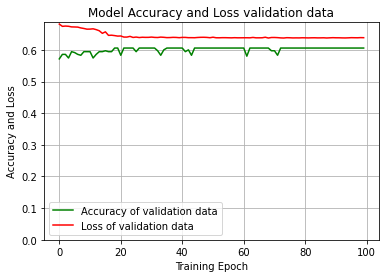

In [39]:
plt.figure(figsize=(6, 4))
#plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
#plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.grid()
plt.legend()
plt.show()

In [50]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

y_pred_test = model.predict(x_test)
y_true = y_test[:,0]
y_pred = (y_pred_test[:,0] > 0.5)*1 #.astype(int)




In [ ]:
cf_mat = confusion_matrix(y_true, y_pred)
f1_score = f1_score(y_true, y_pred)

print("\nPercentage of UP on test data: %0.2f" % np.mean(100*y_true))
print("\nPercentage of UP on predicted test data: %0.2f" % np.mean(100*y_pred))
print("\nConfusion matrix on test data:\n", cf_mat)
print("\nF1 score on test data: %0.2f" % f1_score)


Percentage of UP on test data: 60.23

Percentage of UP on predicted test data: 100.00

Confusion matrix on test data:
 [[ 0 35]
 [ 0 53]]

F1 score on test data: 0.75


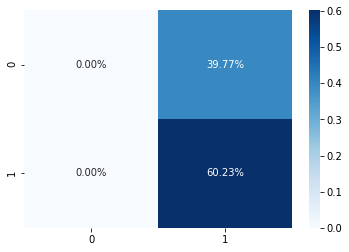

In [61]:
sns.heatmap(cf_mat/np.sum(cf_mat), annot=True, 
            fmt='.2%', cmap='Blues')

# **CNN model**

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Reshape
from tensorflow.keras.layers import Conv1D, Lambda, Flatten

In [41]:
def build_cnn1d_model(input_shape, num_classes):
    
    ## 1D CNN neural network
    model = Sequential()
    model.add(Reshape(input_shape, input_shape=input_shape))
    model.add(Conv1D(8, 16, activation='relu', use_bias=False, padding="causal", strides=1))
    model.add(Conv1D(8, 16, activation='relu', padding="causal", dilation_rate=2))
    #model.add(Conv1D(16, 2, activation='relu', padding="causal", dilation_rate=4))
    #model.add(Conv1D(16, 2, activation='relu', padding="causal", dilation_rate=8))
    model.add(Lambda(lambda x: x[:, -1, :])) ## select just the last observations
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    
    return(model)

In [42]:
input_shape = x_train[0].shape
num_classes = 2

model = build_cnn1d_model(input_shape, num_classes)

model.build((None,) + input_shape)

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 100, 10)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 8)            1280      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 8)            1032      
_________________________________________________________________
lambda (Lambda)              (None, 8)                 0         
_________________________________________________________________
flatten (Flatten)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 18        
Total params: 2,330
Trainable params: 2,330
Non-trainable params: 0
____________________________________________________

In [46]:
## hyper-parameters
BATCH_SIZE = 32
EPOCHS = 100

## compile model with optimizer and loss function
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

## fit!
history = model.fit(x_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/100
9/9 [==============================] - 1s 28ms/step - loss: 642893619.2000 - accuracy: 0.5261 - val_loss: 6174877696.0000 - val_accuracy: 0.4857
Epoch 2/100
9/9 [==============================] - 0s 7ms/step - loss: 692768630.4000 - accuracy: 0.4646 - val_loss: 1531415040.0000 - val_accuracy: 0.4714
Epoch 3/100
9/9 [==============================] - 0s 7ms/step - loss: 364636763.2000 - accuracy: 0.5170 - val_loss: 2417242880.0000 - val_accuracy: 0.5000
Epoch 4/100
9/9 [==============================] - 0s 7ms/step - loss: 362628780.8000 - accuracy: 0.5113 - val_loss: 4608489984.0000 - val_accuracy: 0.5143
Epoch 5/100
9/9 [==============================] - 0s 7ms/step - loss: 351203667.2000 - accuracy: 0.6311 - val_loss: 2377062912.0000 - val_accuracy: 0.5000
Epoch 6/100
9/9 [==============================] - 0s 7ms/step - loss: 364505158.4000 - accuracy: 0.5164 - val_loss: 1916860032.0000 - val_accuracy: 0.4714
Epoch 7/100
9/9 [==============================] - 0s 7ms/step 

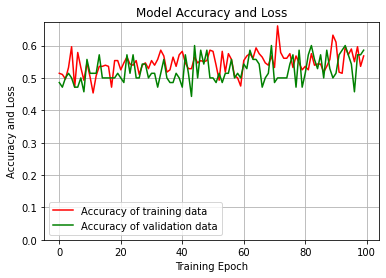

In [57]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "r", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
#plt.plot(history.history['loss'], "r--", label="Loss of training data")
#plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.grid()
plt.legend()
plt.show()

In [49]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

y_pred_test = model.predict(x_test)
y_true = y_test[:,0]
y_pred = (y_pred_test[:,0] > 0.5) #.astype(int)


cf_mat = confusion_matrix(y_true, y_pred)
f1_score = f1_score(y_true, y_pred)e

print("\nPercentage of UP on test data: %0.2f" % np.mean(100*y_true))
print("\nConfusion matrix on test data:\n", cf_mat)
print("\nF1 score on test data: %0.2f" % f1_score)


Percentage of UP on test data: 60.23

Confusion matrix on test data:
 [[28  7]
 [43 10]]

F1 score on test data: 0.29


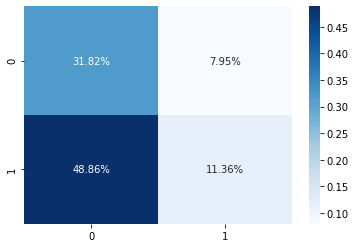

In [58]:
sns.heatmap(cf_mat/np.sum(cf_mat), annot=True, 
            fmt='.2%', cmap='Blues')